# Project 3 – E91 Protocol \& CHSH Inequality

## Dmytro Romaniv
### Student ID: 151958

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import random

N_SINGLETS = 1024
SHOTS = 1

simulator = AerSimulator()

print(f"Environment set up. Simulation will run {N_SINGLETS} singlet states.")

Environment set up. Simulation will run 1024 singlet states.


In [2]:
def create_singlet_source():
    qr = QuantumRegister(2, 'qr')
    cr = ClassicalRegister(4, 'cr')
    qc = QuantumCircuit(qr, cr)

    qc.x(0)
    qc.x(1)
    qc.h(0)
    qc.cx(0, 1)

    return qc

def apply_alice_detector(qc, basis, qubit_index=0, clbit_index=0):
    if basis == 1:
        qc.h(qubit_index)
    elif basis == 2:
        qc.s(qubit_index)
        qc.h(qubit_index)
        qc.t(qubit_index)
        qc.h(qubit_index)
    elif basis == 3:
        pass

    qc.measure(qubit_index, clbit_index)

def apply_bob_detector(qc, basis, qubit_index=1, clbit_index=1):
    if basis == 1:
        qc.s(qubit_index)
        qc.h(qubit_index)
        qc.t(qubit_index)
        qc.h(qubit_index)
    elif basis == 2:
        pass
    elif basis == 3:
        qc.s(qubit_index)
        qc.h(qubit_index)
        qc.tdg(qubit_index)
        qc.h(qubit_index)

    qc.measure(qubit_index, clbit_index)

In [3]:
alice_bases = []
bob_bases = []
results_raw = []

print("Starting simulation of 1024 circuits...")

for i in range(N_SINGLETS):
    b_alice = random.choice([1, 2, 3])
    b_bob = random.choice([1, 2, 3])

    alice_bases.append(b_alice)
    bob_bases.append(b_bob)

    qc = create_singlet_source()
    apply_alice_detector(qc, b_alice)
    apply_bob_detector(qc, b_bob)

    compiled_qc = transpile(qc, simulator)
    job = simulator.run(compiled_qc, shots=1)
    result = job.result()
    counts = result.get_counts(compiled_qc)

    measured_state = list(counts.keys())[0]
    bits = measured_state[-2:]
    bob_bit = int(bits[0])
    alice_bit = int(bits[1])

    results_raw.append({'alice': alice_bit, 'bob': bob_bit})

print("Simulation complete.")
print(f"Sample raw result 0: Bases ({alice_bases[0]}, {bob_bases[0]}), Outcome {results_raw[0]}")

Starting simulation of 1024 circuits...
Simulation complete.
Sample raw result 0: Bases (2, 1), Outcome {'alice': 1, 'bob': 0}


In [4]:
alice_key = []
bob_key = []
mismatches = 0

for i in range(N_SINGLETS):
    b = alice_bases[i]
    b_prime = bob_bases[i]

    a_res = results_raw[i]['alice']
    b_res = results_raw[i]['bob']

    match = False
    if b == 2 and b_prime == 1:
        match = True
    elif b == 3 and b_prime == 2:
        match = True

    if match:
        alice_key.append(a_res)
        bob_corrected = 1 - b_res
        bob_key.append(bob_corrected)

        if a_res != bob_corrected:
            mismatches += 1

print(f"Key Generation Complete.")
print(f"Raw Key Length: {len(alice_key)}")
print(f"Number of mismatching bits (QBER): {mismatches}")
print(f"Alice Key (first 10): {alice_key[:10]}")
print(f"Bob Key   (first 10): {bob_key[:10]}")

Key Generation Complete.
Raw Key Length: 206
Number of mismatching bits (QBER): 0
Alice Key (first 10): [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Bob Key   (first 10): [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


In [5]:
def calculate_expectation(alice_b, bob_b_prime, history_alice_b, history_bob_b, results):
    count_same = 0
    count_diff = 0
    total = 0

    for i in range(len(results)):
        if history_alice_b[i] == alice_b and history_bob_b[i] == bob_b_prime:
            total += 1
            a_val = 1 if results[i]['alice'] == 0 else -1
            b_val = 1 if results[i]['bob'] == 0 else -1

            if a_val == b_val:
                count_same += 1
            else:
                count_diff += 1

    if total == 0: return 0

    expectation = (count_same - count_diff) / total
    return expectation, total

E_XW, n_xw = calculate_expectation(1, 1, alice_bases, bob_bases, results_raw)
E_XV, n_xv = calculate_expectation(1, 3, alice_bases, bob_bases, results_raw)
E_ZW, n_zw = calculate_expectation(3, 1, alice_bases, bob_bases, results_raw)
E_ZV, n_zv = calculate_expectation(3, 3, alice_bases, bob_bases, results_raw)

S_value = E_XW - E_XV + E_ZW + E_ZV

print("--- CHSH Test Results ---")
print(f"<X⊗W> (N={n_xw}): {E_XW:.4f}")
print(f"<X⊗V> (N={n_xv}): {E_XV:.4f}")
print(f"<Z⊗W> (N={n_zw}): {E_ZW:.4f}")
print(f"<Z⊗V> (N={n_zv}): {E_ZV:.4f}")
print("-" * 30)
print(f"Calculated S = {S_value:.4f}")
print(f"Target S     = -2.8284 (-2√2)")

is_entangled = abs(S_value) > 2.0
print(f"Violation of Classical Limit (S > 2)? {is_entangled}")

--- CHSH Test Results ---
<X⊗W> (N=116): -0.7931
<X⊗V> (N=136): 0.7206
<Z⊗W> (N=112): -0.7500
<Z⊗V> (N=118): -0.7797
------------------------------
Calculated S = -3.0434
Target S     = -2.8284 (-2√2)
Violation of Classical Limit (S > 2)? True


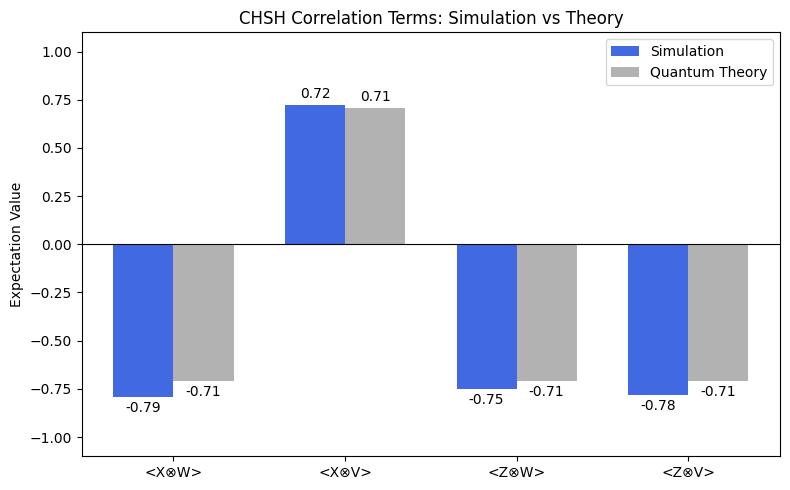

In [10]:
import matplotlib.pyplot as plt
import os

simulated_values = [-0.7931, 0.7206, -0.7500, -0.7797]
theory_values = [-0.7071, 0.7071, -0.7071, -0.7071]
labels = ['<X⊗W>', '<X⊗V>', '<Z⊗W>', '<Z⊗V>']

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar([i - width/2 for i in x], simulated_values, width, label='Simulation', color='royalblue')
rects2 = ax.bar([i + width/2 for i in x], theory_values, width, label='Quantum Theory', color='gray', alpha=0.6)

ax.set_ylabel('Expectation Value')
ax.set_title('CHSH Correlation Terms: Simulation vs Theory')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.ylim(-1.1, 1.1)
plt.tight_layout()
os.makedirs('p3_results', exist_ok=True)
plt.savefig('p3_results/chsh_plot.png')